# Appointment No-Show Prediction

Predicting whether a patient will attend their scheduled medical appointment using demographic and clinical data from Brazil. Missed appointments burden healthcare systems and reduce care quality—this project aims to address that with machine learning.
markdown
Copy code

### Table of Contents
1. [Introduction](#1-introduction)
2. [Data Overview](#2-data-overview)
3. [Data Cleaning](#3-data-cleaning)
4. [Feature Engineering](#4-feature-engineering)
5. [Data Balancing](#5-data-balancing)
6. [Exploratory Data Analysis (EDA)](#6-exploratory-data-analysis-eda)
7. [Chi-Square Test](#7-chi-square-test)
8. [Correlation Matrix (with Limitations)](#8-correlation-matrix-with-limitations)
9. [Model Building](#9-model-building)
10. [Model Evaluation](#10-model-evaluation)
11. [Feature Importance](#11-feature-importance)
12. [Conclusion](#12-conclusion)

### 1. Introduction

This project explores factors that influence whether a patient will miss a scheduled medical appointment using classification models. The dataset includes patient demographics, appointment details, and medical conditions.

### 2. Objective

- Perform data cleaning, exploration, and feature engineering.
- Use statistical tests to find significant associations.
- Train predictive models (Logistic Regression, Random Forest).
- Evaluate models based on accuracy and interpret key features influencing no-shows.

### 3. Data Overview

- Number of rows and columns:  110,527 rows, 14 columns
- Key columns: Age,  Gender, ScheduledDay, Scholarship, AppointmentDay, No-show, SMS_received

### Import Libraries
Importing python libraries  used for handling data, plotting, and machine learning.

In [160]:
# Data manipulation.
import pandas as pd
import numpy as np

# Visualization.
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Set aesthetic style.
sns.set(style="whitegrid")

In [162]:
# Load data.
data = pd.read_csv('KaggleV2-May-2016.csv')

# Preview.
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### 4. Data Cleaning

- Checked for missing values and handled them appropriately.
- Removed duplicates.
- Converted date columns to datetime objects.

In [165]:
data.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [167]:
data.drop_duplicates(inplace=True)
# Converted scheduledday and appointmentday to datetime format.
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'], errors='coerce')
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'], errors='coerce')

### 5. Balancing the Dataset
The original dataset was highly imbalanced, with a significantly higher number of patients who showed up for their appointments compared to those who didn’t. Imbalanced data can lead to biased models that favor the majority class and fail to learn patterns from the minority class.

To address this, we performed random under-sampling of the majority class (show) and selected an equal number of samples (20,000 each) from both classes:

**No-show = Yes** (Patients who missed their appointments)

**No-show = No** (Patients who attend their appointments)

In [170]:
no_show = data[data['No-show'] == 'Yes']
show = data[data['No-show'] == 'No']

In [172]:
# Balancing the dataset.
no_sample = no_show.sample(n=20000, random_state=42)
show_sample = show.sample(n=20000, random_state=42)
df = pd.concat([no_sample, show_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

### 6. Feature Engineering & Encoding
To enhance model performance and extract deeper insights, several meaningful features were engineered from the raw dataset:

 Age Grouping
 Temporal Features
 Communication Features
 Health Risk Features
 Time-of-Day Buckets
 Target Variable Encoding

In [175]:
# Changing data types of columns.
# Patients were categorized into age groups: child, teen, young adult, adult, and senior.
bins = [0, 12, 18, 35, 60, 100]
labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior']
df['age_group'] = pd.cut(df['Age'], bins=bins, labels=labels)

# One-hot encoding was applied to represent these groups numerically.
df = pd.get_dummies(df, columns=['age_group'], drop_first=True)


# Extracted the day of the week of the appointment using .dt.dayofweek.
df['Weekday'] = df['AppointmentDay'].dt.dayofweek

# Created a binary column is_weekend to indicate if the appointment falls on a weekend (saturday or sunday).
df['is_weekend'] = df['Weekday'].apply(lambda x: 1 if x in [5, 6] else 0)

# Extracted the hour of the scheduled appointment as timing of appointment.
df['Timing of Appointment'] = df['ScheduledDay'].dt.hour

# Calculated waiting days — the number of days between scheduling and the actual appointment.
df['Waiting Days'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

# Normalized waiting days to the range [0, 1] using minmaxscaler.
from sklearn.preprocessing import MinMaxScaler
df['Waiting Days Norm'] = MinMaxScaler().fit_transform(df[['Waiting Days']])


# Created sms_wait_ratio, the ratio of sms reminders received to the number of waiting days, to reflect communication intensity.
df['sms_wait_ratio'] = df['SMS_received'] / (df['Waiting Days'] + 1)

# Filling missing values in sms_wait_ratio.
df.fillna({'sms_wait_ratio': 0}, inplace=True)

# Converted gender to a binary column f/m (1 for female, 0 for male).
df['F/M'] = df['Gender'].apply(lambda x:1 if x=='F' else 0)

# Created chronic disease by summing up binary indicators of hypertension, diabetes, alcoholism, and handicap.
df['Chronic Disease'] = df['Hipertension'] + df['Diabetes'] + df['Alcoholism'] + df['Handcap']

# Defined highrisk patients as those aged over 60 with at least one chronic condition.
df['HighRisk'] = df.apply(lambda x:'1' if (x['Chronic Disease']>0 and
                                                 x['Age']>60) else 0, axis=1)
df['HighRisk'] = pd.to_numeric(df['HighRisk'], errors='coerce')

# Computed vulnerability_score by aggregating multiple risk indicators.
df['vulnerability_score'] = df['Diabetes'] + df['Alcoholism'] + df['Handcap'] + df['Chronic Disease']

# Converting no-show to integers.
df['No-show'] = df['No-show'].map({'Yes':1, 'No':0})

# Constructed risk_by_age by weighting highrisk status with age group severity levels.
df['risk_by_age'] = df['HighRisk'] * (
    df['age_group_Senior'] + df['age_group_Adult'] * 0.75 +
    df['age_group_Young Adult'] * 0.5 + df['age_group_Teen'] * 0.25)

# Binned appointment times into three labeled periods: morning, afternoon, and evening.
df['Timing_Label'] = pd.cut(df['Timing of Appointment'], bins=[0, 12, 17, 24], labels=['Morning', 'Afternoon', 'Evening'])

# One-hot encoding was applied to this new timing_label column.
df = pd.get_dummies(df, columns=['Timing_Label'], drop_first=True)

### 7. Dropping Redundant and Irrelevant Columns

After feature engineering, several columns became redundant or no longer useful. These columns were removed to streamline the dataset and avoid multicollinearity:

- `ScheduledDay`, `AppointmentDay`: Already used to calculate new features like `Waiting Days`, `Timing of Appointment`, and `Weekday`.
- `Waiting Days Norm`: We use `Waiting Days` directly or derived features instead.
- `Neighbourhood`: Too granular and difficult to generalize.
- `PatientId`, `AppointmentID`: Unique identifiers with no predictive value.
- `Hipertension`, `Gender`: These were incorporated into composite features (`Chronic Disease`, `F/M`).
- `Chronic Disease`, `HighRisk`: Already used to build `risk_by_age` and `vulnerability_score`.

In [178]:
# Dropping redundant or irrelevant columns after feature engineering.
df.drop(['ScheduledDay', 'Chronic Disease', 'HighRisk', 'Waiting Days Norm', 'Hipertension','Neighbourhood', 'AppointmentDay', 'PatientId', 'AppointmentID', 'Gender'], inplace=True, axis=1)

### 8. Correlation Matrix

To explore potential relationships between numerical features, we computed the Pearson correlation matrix and visualized it using a heatmap.

This matrix helps identify multicollinearity between features, which is important when selecting features for certain models (linear regression).

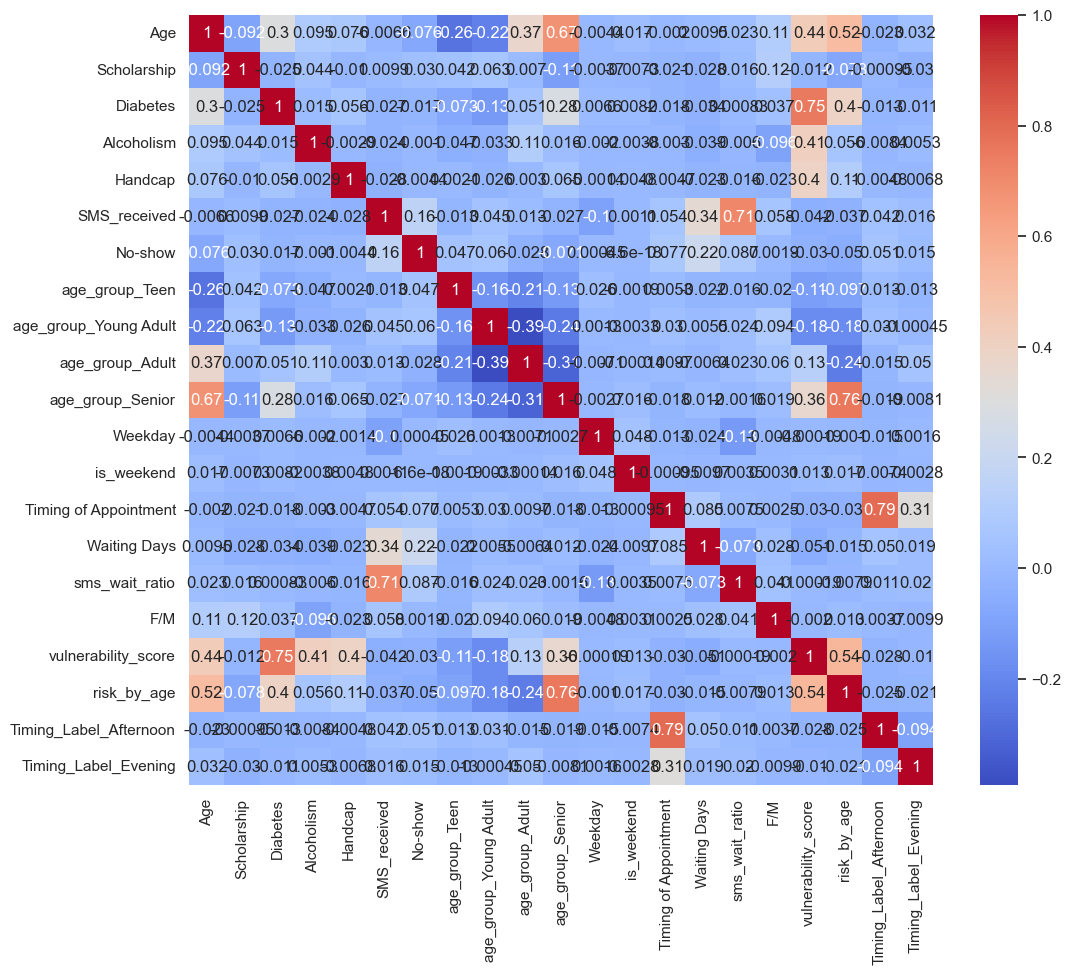

In [181]:
# Compute the correlation matrix.
corr = df.corr()

# Plot the heatmap.
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

> **Note**: While the correlation matrix provides insights into linear relationships between features, it is not the most appropriate tool for evaluating associations between categorical variables. For this, we used the Chi-square test to assess statistical significance more accurately.

### 9. Chi-square Test Results: Association with No-show Status

The Chi-square test was performed to evaluate whether there's a statistically significant association between various categorical features and the likelihood of a patient not showing up for their appointment.

In [185]:
import pandas as pd
from scipy.stats import chi2_contingency

# Define the categorical features to test.
categorical_features = ['F/M', 'Scholarship', 'risk_by_age', 'age_group_Senior', 'vulnerability_score']

# Run chi-square test for each feature.
for feature in categorical_features:
    table = pd.crosstab(df[feature], df['No-show'])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"\nFeature: {feature}")
    print(f"Chi-square Statistic = {chi2:.2f}, Degrees of Freedom = {dof}, p-value = {p:.4f}")
    if p < 0.05:
        print("=> Statistically significant association with No-show")
    else:
        print("=> No significant association")


Feature: F/M
Chi-square Statistic = 0.14, Degrees of Freedom = 1, p-value = 0.7053
=> No significant association

Feature: Scholarship
Chi-square Statistic = 36.65, Degrees of Freedom = 1, p-value = 0.0000
=> Statistically significant association with No-show

Feature: risk_by_age
Chi-square Statistic = 98.78, Degrees of Freedom = 1, p-value = 0.0000
=> Statistically significant association with No-show

Feature: age_group_Senior
Chi-square Statistic = 202.78, Degrees of Freedom = 1, p-value = 0.0000
=> Statistically significant association with No-show

Feature: vulnerability_score
Chi-square Statistic = 97.42, Degrees of Freedom = 8, p-value = 0.0000
=> Statistically significant association with No-show


####  Interpretation:
- **Gender** does not significantly affect appointment attendance.
- Factors like **Scholarship**, **High Risk by Age**, **Senior Age Group**, and **Chronic Disease Severity (vulnerability_score)** have **strong associations** with the no-show behavior.
- These variables are potential **key predictors** and should be prioritized during model training and feature importance analysis..       |

### 10. Exploratory Data Analysis (EDA)

To better understand how different features relate to patient no-shows, we used `countplot` visualizations to compare the distribution of 'Show' vs 'No-show' across key variables.

The following plots help identify potential patterns and high-risk grou
- **Risk by Age:** Combines chronic conditions and age to show how health risk influences attendance.
- **Disease Severity:** Aggregated score reflecting the presence of chronic conditions.alues.
- **Gender:** Comparing no-show rates between males and females.
- **Scholarship:** Examining whether receiving financial aid influences attendance.
- **Age Group:** Categorized age bands (e.g., Teen, Adult, Senior) and their no-show tonditions.

These visualizations guide feature selection and model development by highlighting variables that show meaningful class separations.

### 10.1 No-show Rates by Age-Related High Risk Status

The following countplot visualizes the number of appointments categorized by the `risk_by_age` feature and whether the patient showed up or not.

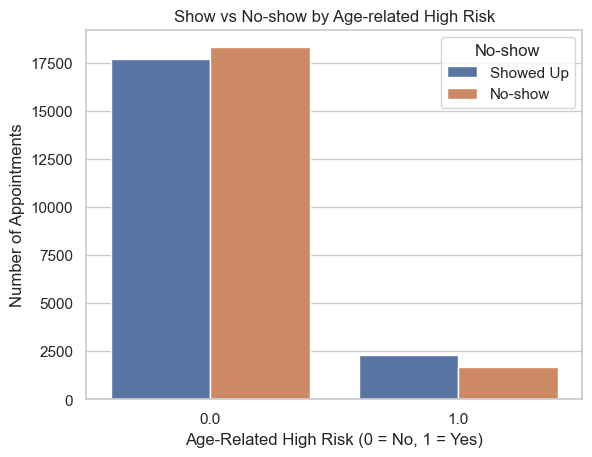

In [190]:
# Countplot to compare no-show rates by high_risk.
sns.countplot(x='risk_by_age', hue='No-show', data=df)
plt.title('Show vs No-show by Age-related High Risk')
plt.xlabel('Age-Related High Risk (0 = No, 1 = Yes)')
plt.ylabel('Number of Appointments')
plt.legend(title='No-show', labels=['Showed Up', 'No-show'])
plt.show()

### 10.2. No-show Rates by Disease Severity

The following countplot visualizes how disease severity, represented by the `vulnerability_score`, affects appointment attendanc It  helps evaluate whether patients with one or more chronic diseases are more likely to miss their appointments compared to those without chronic conditions.

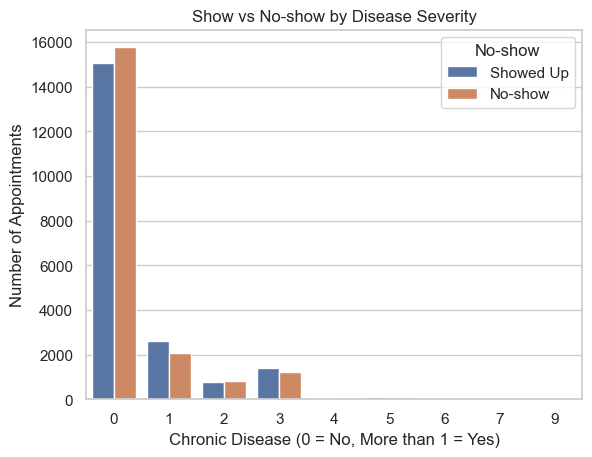

In [193]:
# Countplot to compare no-show rates by disease severity.

sns.countplot(x='vulnerability_score', hue='No-show', data=df)
plt.title('Show vs No-show by Disease Severity')
plt.xlabel('Chronic Disease (0 = No, More than 1 = Yes)')
plt.ylabel('Number of Appointments')
plt.legend(title='No-show', labels=['Showed Up', 'No-show'])
plt.show()

### 10.3. No-show Rates by Gender

The following countplot displays the relationship between patient gender and appointment attendanc This plot helps analyze whether gender (Female or Male, represented by F/M) has any influence on the likelihood of showing up for appointments.
.

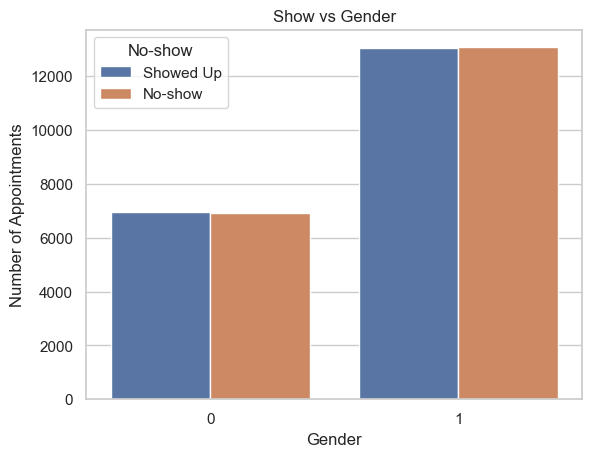

In [196]:
# Countplot to compare no-show rates by gender.

sns.countplot(x='F/M', hue='No-show', data=df)
plt.title('Show vs Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Appointments')
plt.legend(title='No-show', labels=['Showed Up', 'No-show'])
plt.show()

### 10.4. No-show Rates by Scholarship Status

The following countplot examines whether receiving a scholarship influences appointment attendance. This plot helps determine if patients who receive financial assistance (scholarships) are more or less likely to miss their appointments.

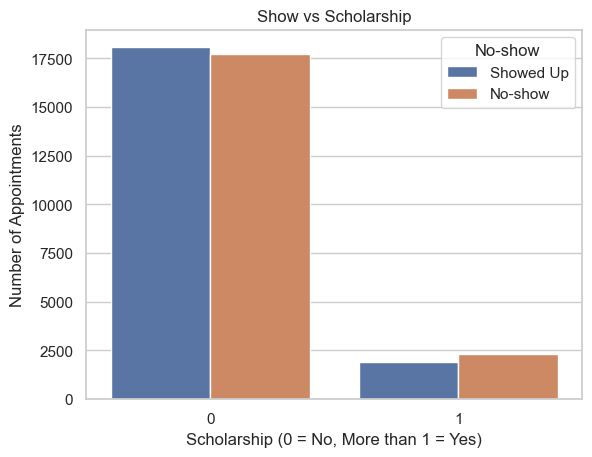

In [199]:
# Countplot to compare no-show rates by scholarship.

sns.countplot(x='Scholarship', hue='No-show', data=df)
plt.title('Show vs Scholarship')
plt.xlabel('Scholarship (0 = No, More than 1 = Yes)')
plt.ylabel('Number of Appointments')
plt.legend(title='No-show', labels=['Showed Up', 'No-show'])
plt.show()

### 10.5. No-show Rates by Age Group

The following bar plot visualizes the number of appointments across different age groups and their no-show statu This plot helps explore trends in appointment attendance across different age values. It can reveal whether younger or older patients are more likely to miss their appointments..

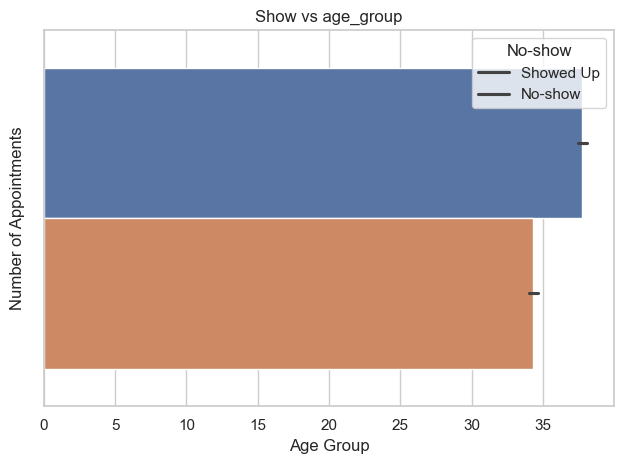

In [201]:
# Countplot to compare no-show rates by age group.

sns.barplot(x='Age', hue='No-show', data=df)
plt.title('Show vs age_group')
plt.xlabel('Age Group')
plt.ylabel('Number of Appointments')
plt.legend(title='No-show', labels=['Showed Up', 'No-show'])
plt.tight_layout()
plt.show()

### 11. Model Building

We trained two models:

- Logistic Regression
- Random Forest Classifier

### 11.1 Logistic Regression Model for No-show Prediction

The following code trains a logistic regression model to predict patient no-shows using the preprocessed dataset.

In [205]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. define x and y.
X = df.drop(['No-show'], axis=1)  # Drop target + identifiers
y = df['No-show']

# 2. split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. train the model.
model = LogisticRegression(max_iter=1000)  # Increase max_iter to prevent convergence warning
model.fit(X_train, y_train)

# 4. predict and evaluate.
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.644
Confusion Matrix:
 [[2674 1326]
 [1522 2478]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.67      0.65      4000
           1       0.65      0.62      0.64      4000

    accuracy                           0.64      8000
   macro avg       0.64      0.64      0.64      8000
weighted avg       0.64      0.64      0.64      8000



### 11.2 Random Forest Classifier for No-show Prediction

The following code implements a Random Forest Classifier to predict whether a patient will show up for their appointment.
Random Forest is an ensemble learning method that reduces overfitting and improves prediction accuracy.

max_depth=5 restricts tree complexity to prevent overfitting.

The model outputs:

Accuracy Score – overall correctness of predictions.

Classification Report – includes precision, recall, and F1-score.
This model can be compared with other classifiers like Logistic Regression to determine the best-performing approach.

In [208]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Define features and target.
X = df.drop(['No-show'], axis=1) 
y = df['No-show']

# Train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)


# Predictions.
y_pred = rf_model.predict(X_test) 

# Evaluation.
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score:  0.673375
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.48      0.60      4000
           1       0.63      0.86      0.73      4000

    accuracy                           0.67      8000
   macro avg       0.70      0.67      0.66      8000
weighted avg       0.70      0.67      0.66      8000

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.48      0.60      4000
           1       0.63      0.86      0.73      4000

    accuracy                           0.67      8000
   macro avg       0.70      0.67      0.66      8000
weighted avg       0.70      0.67      0.66      8000



### 12. 5-Fold Cross-Validation for Logistic Regression

The following code performs 5-fold cross-validation using a logistic regression model to evaluate the consistency and reliability of its performanc 
eCross-validation splits the dataset into 5 folds, trains the model on 4 folds, and tests on the remaining fold — repeating this 5 times.

cross_val_score returns accuracy scores for each fold.

The mean accuracy provides an overall estimate of model performance and generalizability.

Cross-validation is crucial for detecting overfitting and evaluating how the model performs on unseen data..

In [211]:
# Cross-validation.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Create the model.
model = LogisticRegression(max_iter=1000)

# Define features and target.
X = df.drop(['No-show'], axis=1)  # Drop target + identifiers
y = df['No-show']

# Run 5-fold cross-validation on accuracy.
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation accuracy scores: [0.634    0.63175  0.633875 0.634625 0.639   ]
Mean accuracy: 0.63465


### 13. Feature Importance from Logistic Regression Coefficients

After training the logistic regression model with cross-validation, the following code extracts and displays feature importance based on model coefficients.

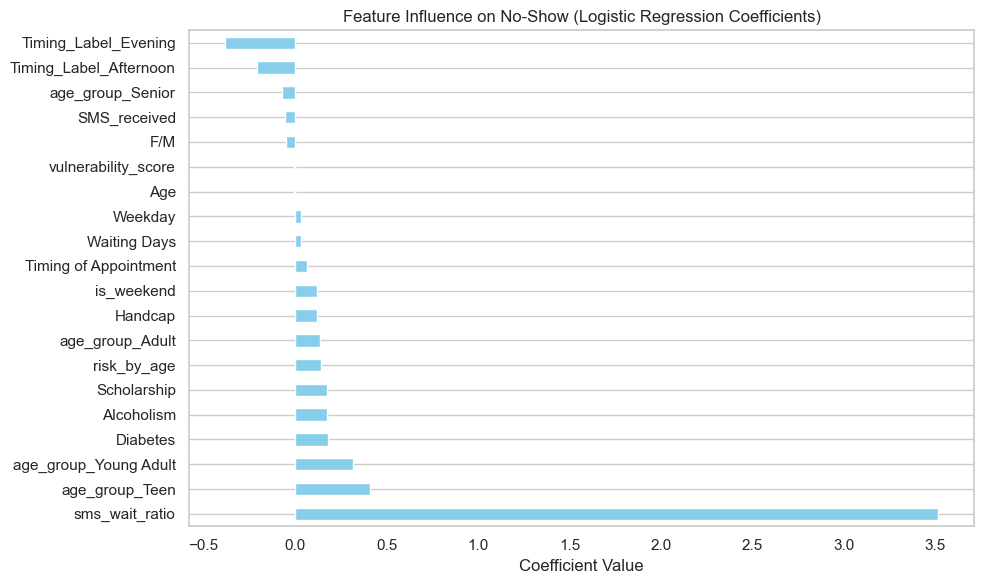

In [213]:
import pandas as pd

# Get feature names and their coefficients.
coefficients = pd.Series(log_reg_cv.coef_[0], index=X.columns)
# 3. plot feature influence.
plt.figure(figsize=(10, 6))
coefficients.sort_values(ascending=False).plot(kind='barh', color='skyblue')
plt.title("Feature Influence on No-Show (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Each coefficient reflects the strength and direction of the relationship between a feature and the likelihood of a no-show.

Positive coefficients → Increase likelihood of a no-show.

Negative coefficients → Decrease likelihood of a no-show.

Sorting the coefficients helps identify the most influential predictors.

This step is valuable for interpreting model behavior and identifying key factors contributing to patient appointment attendance.

Logistic regression identified sms_wait_ratio, teen/young adult age groups, and chronic conditions like diabetes and alcoholism as strong predictors of no-shows. Evening and afternoon appointments were linked with improved attendance, suggesting possible time-of-day intervention opportunities. Coefficients were derived with L2 regularization (C=2.78), optimizing bias-variance tradeoff.

### 14. Model Comparison

We compare Logistic Regression, Logistic Regression with Cross-Validation, and Random Forest based on accuracy and classification reports.

### 15. Final Conclusion

This project explored patterns and predictive factors associated with patient appointment no-shows using a real-world dataset. Through exploratory data analysis (EDA), statistical tests, and machine learning, the following key insights emerged:

- **High-Risk Groups**: Senior citizens and patients with chronic conditions showed significantly higher no-show rates.
- **Socioeconomic Factors**: Patients receiving a scholarship (indicating lower socioeconomic status) were more likely to miss appointments.
- **Gender and Age Effects**: Gender did not have a statistically significant association, while certain age brackets showed varied attendance behavior.
- **Feature Relevance**: Logistic regression coefficients and chi-square tests helped identify the most influential frship`).
- **Model Performance**: Logistic regression and random forest classifiers provided reasonable predictive power, with accuracy scores above baseline. Cross-validation ensured model generalizability.
- **Balanced Dataset**: Data balancing helped address class imbalance, improving the model’s ability to dehows.nntion planning.

This project not only highlights the value of data-driven insights in healthcare operations but also demonstrates how predictive modeling can support proactive strategies to reduce missed appointments and utilization.ce utilization.
trest.